In [1]:
import os
from os.path import join, exists, basename, dirname, expanduser
from glob import glob
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import rioxarray as rxa
from scipy import stats
from sklearn import metrics

with open(expanduser('~/scratch/data/uavsar/image_fps'), 'rb') as f:
    image_fps = pickle.load(f)

image_fps = [f for f in image_fps if f['fp'].endswith('.unw.grd.tiff')]
netcdf_fps = '/bsuhome/zacharykeskinen/scratch/data/uavsar/images/vv_coherence'

cor_vv = {}
for fp in glob(join(netcdf_fps, '*')):
    with open(fp, 'rb') as f:
        cor_vv[basename(fp).split('.')[0]] = pickle.load(f)

In [2]:
def clean_two_np(arr1, arr2):
    buff = arr1
    arr1 = arr1[(~np.isnan(arr1)) & (~np.isnan(arr2))]
    arr2 = arr2[(~np.isnan(buff)) & (~np.isnan(arr2))]
    return arr1, arr2

def datarray_to_numpy(x, y):
    if type(x)== xr.core.dataarray.DataArray:
        x_dirty = x.values.ravel()
        y = y.values.ravel()
    else:
        x_dirty = x
    x = x_dirty[(~np.isnan(x_dirty)) & (~np.isnan(y))]
    y = y[(~np.isnan(x_dirty)) & (~np.isnan(y))]
    return x, y

def r2_value(x, y):
    x, y = datarray_to_numpy(x,y)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    print(f'slope: {slope}. intercept: {intercept}. r_value {r_value}. p value: {p_value}')
    return slope, intercept, r_value, p_value, x, y

def mann_test(x, y, xlabel = 'x', ylabel = 'y'):
    x, y = datarray_to_numpy(x,y)
    stat, p = mannwhitneyu(x, y)   
    print(f'Comparison of {xlabel} vs {ylabel} center has a p value of {p:.10f} of not being from same distribution with {len(x)} observations.')
    if p < 0.1:
        print(f'Median of {xlabel}: {np.median(x)} compared to median of {ylabel}: {np.median(y)}')

In [3]:
for loc, ds in cor_vv.items():
    for band in ds.band.values:
        sub = [f for f in image_fps if (band in f['fp']) & (f['pol'] == 'VV')]
        fps = sub[0]
        direction = basename(fps['inc']).split('_')[1][:3]
        inc = rxa.open_rasterio(fps['inc'])
        if f'{direction}-inc' not in cor_vv[loc].data_vars:
            cor_vv[loc][f'{direction}-inc'] = inc.rio.reproject_match(cor_vv[loc])[0]

In [4]:
incs = []
cors = []
for loc, ds in cor_vv.items():
    for band in ds.band.values:
        direction = band.split('_')[1][:3]
        inc_name = f'{direction}-inc'
        inc = ds[inc_name]
        cor = ds.sel({'band':band})
        if cor.band.values.size > 1:
            cor = cor.isel({'band':0})
        insclean, csclean = clean_two_np(inc.values.ravel(), cor['cor_vv'].values.ravel())
        incs.append(insclean)
        cors.append(csclean)
incs = np.concatenate(incs)
cors = np.concatenate(cors)

In [5]:
slope, intercept,r,p, _, _ = r2_value(incs, cors)

slope: -0.1838397293401049. intercept: 0.7151002474796886. r_value -0.25255146641794896. p value: 0.0


In [6]:
a2, a1, int = np.polyfit(incs, cors, 2)

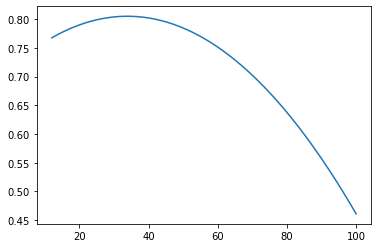

In [7]:
xs = np.linspace(np.deg2rad(12), np.deg2rad(100), 200)
ys = a2 *  xs**2+ a1 * xs + intercept
plt.plot(np.rad2deg(xs), ys)

In [8]:
y_predicted = a2 *  incs**2+ a1 * incs + intercept

In [9]:
a

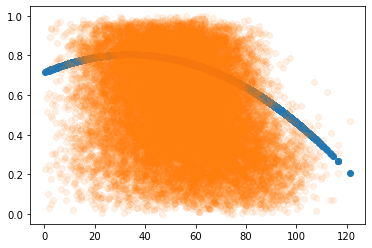

In [14]:
plt.scatter(np.rad2deg(incs)[::10000], y_predicted[::10000])
plt.scatter(np.rad2deg(incs)[::10000], cors[::10000], alpha = 0.1)

In [10]:
rms

0.30088892704921305

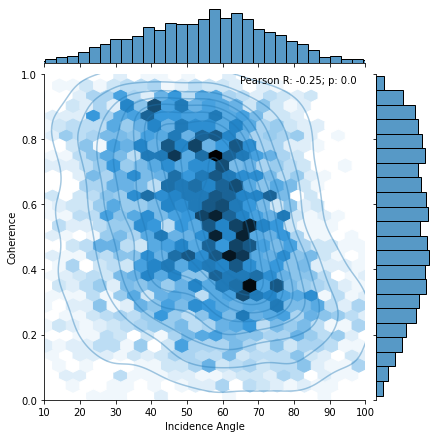

In [84]:
plt.Figure(figsize = (12,8))
g = sns.jointplot(x = np.rad2deg(incs[::50000]), y = cors[::50000], kind = 'hex', xlim = [10, 100], ylim = [0,1])
# g.plot_joint(sns.scatterplot, color="C0", zorder=1, alpha = 0.1)
g.plot_joint(sns.kdeplot, color="C0", zorder=1, alpha = 0.4)
xs = np.linspace(np.deg2rad(12), np.deg2rad(100), 200)
ys = slope * xs + intercept
# sns.lineplot(x = np.rad2deg(xs),y = ys, zorder = 2, color = 'C1', ax = g.ax_joint)
g.ax_joint.annotate(text = f'Pearson R: {r:.2}; p: {p:.2}', xy = [65,0.97])
g.ax_joint.set_xlabel('Incidence Angle')
g.ax_joint.set_ylabel('Coherence')
plt.savefig(join('/bsuhome/zacharykeskinen/uavsar/figures/coherence_spatial/incidence-angle', 'all-inc-coh.png'))

In [83]:
# data_fp = '/bsuhome/zacharykeskinen/scratch/data/uavsar/coherence'
# with open(join(data_fp,'cor_vv.pkl'), 'wb') as f:
#     pickle.dump(cor_vv, f)